---
title: "weight data"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---


Now that we have height data covered, it's time we deal with weight data.

Yes, I am **VERY WELL AWARE** that weight is a force, and it is not measured in kg. Nevertheless, I will use the word weight in the colloquial sense, and for all purposes it is a synonym for mass.

This analysis will follow the same steps we used for height data, therefore I will skip some of the intermediate steps. Whenever there are differences, I will point them out.

In [41]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.interpolate import UnivariateSpline
import matplotlib.animation as animation
from scipy.stats import norm
from scipy.stats import lognorm
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'
%matplotlib widget

In [2]:
#| code-summary: "define useful arrays"
age_list = np.round(np.arange(2.0, 20.1, 0.1), 1)
weight_list = np.round(np.arange(10, 100, 0.1), 1)

We will load all the digitized data for the weight curves, and will interpolate.

In [9]:
#| code-summary: "interpolate all growth curves"
col_names = ['p05', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95']
file_names_boys = ['boys-p05.csv', 'boys-p10.csv', 'boys-p25.csv', 'boys-p50.csv',
                   'boys-p75.csv', 'boys-p90.csv', 'boys-p95.csv',]
file_names_girls = ['girls-p05.csv', 'girls-p10.csv', 'girls-p25.csv', 'girls-p50.csv',
                   'girls-p75.csv', 'girls-p90.csv', 'girls-p95.csv',]

# create dataframe with age column
df_boys = pd.DataFrame({'age': age_list})
df_girls = pd.DataFrame({'age': age_list})
# loop over file names and read in data
for i, file_name in enumerate(file_names_boys):
    # read in data
    df_temp = pd.read_csv('../archive/data/weight/' + file_name, names=['age','weight'])
    spline = UnivariateSpline(df_temp['age'], df_temp['weight'], s=0.5)
    df_boys[col_names[i]] = spline(age_list)
for i, file_name in enumerate(file_names_girls):
    # read in data
    df_temp = pd.read_csv('../archive/data/weight/' + file_name, names=['age','weight'])
    spline = UnivariateSpline(df_temp['age'], df_temp['weight'], s=0.5)
    df_girls[col_names[i]] = spline(age_list)

# make age index
df_boys.set_index('age', inplace=True)
df_boys.index = df_boys.index.round(1)
df_boys.to_csv('../archive/data/weight/boys_weight_vs_age_combined.csv', index=True)
df_girls.set_index('age', inplace=True)
df_girls.index = df_girls.index.round(1)
df_girls.to_csv('../archive/data/weight/girls_weight_vs_age_combined.csv', index=True)

Let's see now the results:

In [10]:
#| code-summary: "show dataframe for girls"
#| code-fold: false
df_girls

,p05,p10,p25,p50,p75,p90,p95
age,,,,,,,
2.0,10.169139,10.527385,11.117607,12.111512,12.934594,13.970137,14.662625
2.1,10.312243,10.674421,11.291813,12.276811,13.155592,14.191386,14.907424
2.2,10.455176,10.821547,11.465113,12.443392,13.376209,14.415799,15.155615
2.3,10.597984,10.968806,11.637596,12.611299,13.596546,14.643380,15.407214
2.4,10.740711,11.116243,11.809350,12.780573,13.816707,14.874137,15.662236
...,...,...,...,...,...,...,...
19.6,46.015792,48.041956,52.097485,57.744985,65.357860,74.916720,82.545975
19.7,46.008755,48.085732,52.168559,57.855278,65.511084,75.011896,82.648322
19.8,45.997560,48.129771,52.240501,57.969161,65.669232,75.094395,82.748961


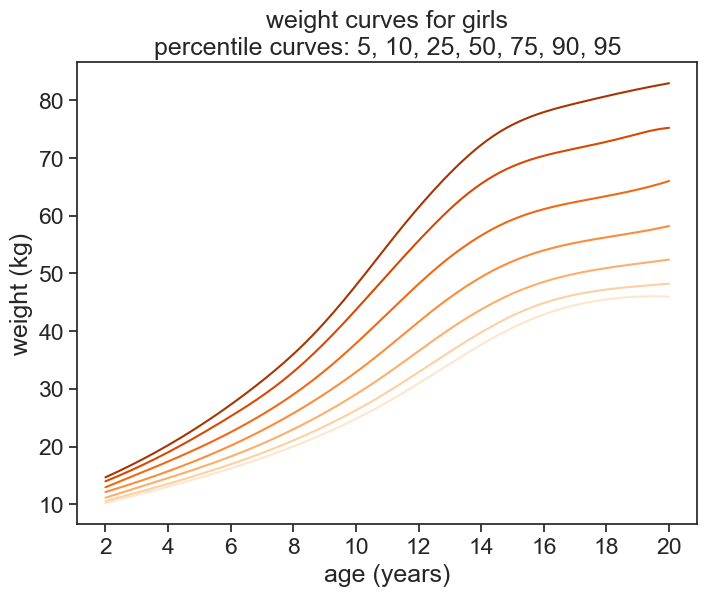

In [11]:
#| code-summary: "show all interpolated curves for girls"
fig, ax = plt.subplots(figsize=(8, 6))
# loop over col_names and plot each column
colors = sns.color_palette("Oranges", len(col_names))
for col, color in zip(col_names, colors):
    ax.plot(df_girls.index, df_girls[col], label=col, color=color)
ax.set(xlabel='age (years)',
       ylabel='weight (kg)',
       xticks=np.arange(2, 21, 2),
       title="weight curves for girls\npercentile curves: 5, 10, 25, 50, 75, 90, 95",
       );

Let's now see the percentiles for girls age 20.

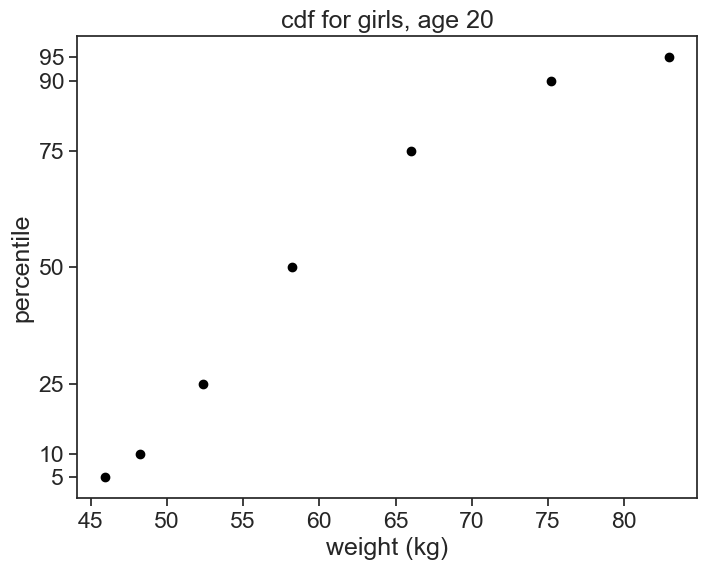

In [12]:
#| code-summary: "plot cdf for girls, age 20"
fig, ax = plt.subplots(figsize=(8, 6))
percentile_list = np.array([5, 10, 25, 50, 75, 90, 95])
data = df_girls.loc[20.0]
ax.plot(data, percentile_list, ls='', marker='o', markersize=6, color="black")
ax.set(xlabel='weight (kg)',
         ylabel='percentile',
         yticks=percentile_list,
         title="cdf for girls, age 20"
         );

This time, I am not so sure that a normal (gaussian) distribution is a good fit for the data. I check if a log-normal distribution does the job.

In [58]:
#| code-summary: "define functions"
def erf_model(x, mu, sigma):
    return 50 * (1 + erf((x - mu) / (sigma * np.sqrt(2))) )
def erf_lognormal_model(x, mu, sigma):
    return 50 * (1 + erf((np.log(x) - mu) / (sigma * np.sqrt(2))) )
def pdf_lognormal(x, mu, sigma):
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
# initial guess for parameters: [mu, sigma]
p0 = np.array([50, 3])
# Calculate R-squared
def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

In [47]:
#| code-summary: "fit model to data"
data = df_girls.loc[20.0]
params, _ = curve_fit(erf_model, data, percentile_list, p0=p0,
                        bounds=([10, 1],   # lower bounds for mu and sigma
                                [100, 20])  # upper bounds for mu and sigma
                        )
params2, _ = curve_fit(erf_model, np.log(data), percentile_list, p0=np.log(p0),
                        bounds=([np.log(10), 0],   # lower bounds for mu and sigma
                                [np.log(100), np.log(20)])  # upper bounds for mu and sigma
                        )
params3, _ = curve_fit(erf_lognormal_model, data, percentile_list, p0=p0,
                        bounds=([10, 1],   # lower bounds for mu and sigma
                                [100, 20])  # upper bounds for mu and sigma
                        )
# store the parameters in the dataframe
percentile_predicted = erf_model(data, *params)
percentile_predicted2 = erf_model(np.log(data), *params2)
percentile_predicted3 = erf_model(np.log(data), *params3)


# R-squared value
r2 = calculate_r2(percentile_list, percentile_predicted)
r2b = calculate_r2(percentile_list, percentile_predicted2)
r2c = calculate_r2(percentile_list, percentile_predicted3)

In [48]:
np.log(data)

p05    3.827837
p10    3.875763
p25    3.958673
p50    4.064035
p75    4.189673
p90    4.320356
p95    4.418177
Name: 20.0, dtype: float64

In [49]:
print(params, r2)

[59.26016626  9.79523675] 0.9902149628457501


In [50]:
print(np.exp(params2),r2b)

[58.87878053  1.18549324] 0.9963888462453959


In [51]:
print(np.exp(params3),r2c)

[5.18470553e+21 2.00855369e+01] -2.0588235294117645


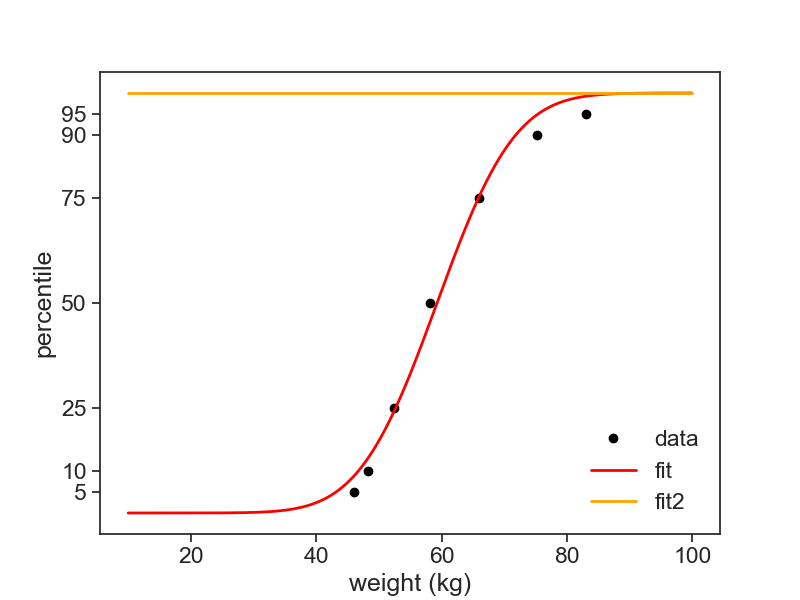

In [57]:
#| code-summary: "show results"
fig, ax = plt.subplots(figsize=(8, 6))
percentile_list = np.array([5, 10, 25, 50, 75, 90, 95])
data = df_girls.loc[20.0]
ax.plot(data, percentile_list, ls='', marker='o', markersize=6, color="black", label='data')
fit = erf_model(weight_list, *params)
# fit2 = np.exp(erf_model(np.log(weight_list), *(np.log(params))))
ax.plot(weight_list, fit, label='fit', color="red", linewidth=2)
# ax.plot(weight_list, 100*lognorm.cdf(weight_list, loc=np.exp(params2[0]), s=1*np.exp(params2[1]) ), label='fit2', color="orange", linewidth=2)
ax.plot(weight_list, 100*lognorm.cdf(weight_list, loc=params2[0], s=params2[1] ), label='fit2', color="orange", linewidth=2)

# ax.text(150, 75, f'$\mu$ = {params[0]:.1f} cm\n$\sigma$ = {params[1]:.1f} cm\nR$^2$ = {r2:.6f}',
        # fontsize=14, bbox=dict(facecolor='white', alpha=0.5))
ax.legend(frameon=False)
ax.set(xlabel='weight (kg)',
    #    xlim=(140, 190),
         ylabel='percentile',
         yticks=percentile_list,
        #  title="the data is very well fitted by a normal distribution"
         );

In [54]:
np.exp(params2[1])

np.float64(1.1854932445401833)